In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from collections import defaultdict

In [2]:
# Chose the benchmark from spec, spec-stripped, spec-opt and spec-opt-stripped.

class BenchmarkType():
    path = None
    #clean_dict = {}
    callsite_dict = {}
    fun_dict = {}
    model_stat = {}

In [3]:
specint = ["400.perlbench", "401.bzip2", "403.gcc.hs", "445.gobmk", "456.hmmer", \
              "458.sjeng.hs", "464.h264ref.hs", "471.omnetpp", "473.astar", "483.xalancbmk"]
specfp = ["433.milc", "444.namd", "447.dealII", "450.soplex", "453.povray", "482.sphinx3"]
realworld = ["nginx-1.22.1", "postgresql-12.0", "trafficserver-6.2.3", "tor", "node-v10.24.0"]

def ParaseBenchmarks(bench):
    benchmark_type = BenchmarkType()
    path = f"/volatile/zephyr/Ruturaj/cfi_project/bcfi_bench/{bench}/"
    benchmarks = specint + specfp + realworld
    binaries = ["perlbench-debug.exe", "bzip2.exe", "gcc.exe", "gobmk.exe", "hmmer.exe", \
                "sjeng.exe", "h264ref.exe", "omnetpp.exe", "astar.exe", "xalancbmk.exe", \
               "milc.exe", "namd.exe", "dealII.exe", "soplex.exe", "povray.exe", \
                "sphinx.exe", "nginx.exe", "postgres.exe", "traffic_server.exe", "tor.exe", "node.exe"]

    clean_dict = {}
    callsite_dict = {}
    fun_dict = {}

    for i, benchmark in enumerate(benchmarks):
        #clean_df = pd.read_csv(os.path.join(path+benchmark, binaries[i] + "-clean.csv"), \
        #index_col=0, header=[0])
        fun_df = pd.read_csv(os.path.join(path+benchmark, binaries[i] + "-fun-clean.csv"), \
                             header=[0])
        callsite_df = pd.read_csv(os.path.join(path+benchmark, binaries[i] + "-callsite-clean.csv"), \
                                  index_col=0, header=[0])

        ######## Clean clean_df and store. ########

        # Drop rows with Nan values. Note: this could remove the ligimate callsites.
        #clean_df = clean_df.dropna(how="any")

        # Sort the dataframe on "Params".
        #clean_df = clean_df.sort_values("Params")

        # add SrcType (IFCC)_ida if absent
        #if "SrcType (IFCC)_ida" not in clean_df:
        #    clean_df["SrcType (IFCC)_ida"] = 0
        #if "SafeSrcType (IFCC-safe)_ida" not in clean_df:
        #    clean_df["SafeSrcType (IFCC-safe)_ida"] = 0

        # Convert the dataframe type to int (for all the columns).
        #columns = ["Params_ida", "SrcType (IFCC)_ida", "SafeSrcType (IFCC-safe)_ida", \
        #"BinType (TypeArmor)_ida", \
        #          "Baseline_ida"]
        #clean_df[columns] = clean_df[columns].astype(int)

        # Calculate differences in each column.
        #clean_df["Param_match"] = np.where(clean_df["Params"] == clean_df["Params_ida"], 1, 0)
        #clean_df["SrcType_match"] = \
        # np.where(clean_df["SrcType (IFCC)"] == clean_df["SrcType (IFCC)_ida"], 1, 0)
        #clean_df["SafeSrcType_match"] = np.where(clean_df["SafeSrcType (IFCC-safe)"] \
        #                                == clean_df["SafeSrcType (IFCC-safe)_ida"], 1, 0)
        #clean_df["BinType_match"] = np.where(clean_df["BinType (TypeArmor)"] \
        #                                     == clean_df["BinType (TypeArmor)_ida"], 1, 0)

        #clean_dict[benchmark] = clean_df

        ######## Clean callsite_df and store. ########

        # Drop rows with Nan values. Note: this could remove the ligimate callsites.
        callsite_df = callsite_df.dropna(how="any")

        # Convert the dataframe type to int (for all the columns).
        columns = ["Arg1_ida", "Arg2_ida", "Arg3_ida", "Arg4_ida", "Arg5_ida", \
                   "Arg6_ida", "Arg7_ida", "Return_ida"]
        callsite_df[columns] = callsite_df[columns].astype(int)

        callsite_dict[benchmark] = callsite_df

        ######## Clean fun_df and store. ########
        
        # Drop rows with Nan values. Note: this could remove the ligimate callsites.
        fun_df = fun_df.dropna(how="any")
        
        # Convert the dataframe type to int (for all the columns).
        columns = ["Arg1_ida", "Arg2_ida", "Arg3_ida", "Arg4_ida", "Arg5_ida", \
                   "Arg6_ida", "Arg7_ida", "Return_ida"]
        fun_df[columns] = fun_df[columns].astype(int)
        
        fun_dict[benchmark] = fun_df

    benchmark_type.path = path
    benchmark_type.clean_dict = clean_dict
    benchmark_type.callsite_dict = callsite_dict
    benchmark_type.fun_dict = fun_dict
    
    return benchmark_type

spec = ParaseBenchmarks("spec-opt")
#spec_str = ParaseBenchmarks("spec-stripped")
#spec_opt = ParaseBenchmarks("spec-opt")
spec_opt_str = ParaseBenchmarks("spec-opt-stripped")

In [4]:
def match_targets_callsites(benchmark):
    print(benchmark)
    spec_opt_str.callsite_dict[benchmark] = \
        spec_opt_str.callsite_dict[benchmark][spec_opt_str.callsite_dict[benchmark].\
        Ins_ida.isin(spec.callsite_dict[benchmark].Ins_ida)]
    spec_opt_str.fun_dict[benchmark] = \
        spec_opt_str.fun_dict[benchmark][spec_opt_str.fun_dict[benchmark].\
        Function.isin(spec.fun_dict[benchmark].Function)]

for benchmark in spec.callsite_dict.keys():
    match_targets_callsites(benchmark)

400.perlbench
401.bzip2
403.gcc.hs
445.gobmk
456.hmmer
458.sjeng.hs
464.h264ref.hs
471.omnetpp
473.astar
483.xalancbmk
433.milc
444.namd
447.dealII
450.soplex
453.povray
482.sphinx3
nginx-1.22.1
postgresql-12.0
trafficserver-6.2.3
tor
node-v10.24.0


In [5]:
def decode(encoding, recurse=False, arm=False):
    # check whether the type is void or non-void for typearmor.
    if arm:
        return "0" if encoding == 1 else "1"
    ret = ""
    if encoding == 0:
        return "0"
    if encoding == 1:
        ret = "Void"
    elif encoding == 2:
        ret = "Int1"
    elif encoding == 3:
        ret = "Int8"
    elif encoding == 4:
        ret = "Int16"
    elif encoding == 5:
        ret = "Int32"
    elif encoding == 6:
        ret = "Int64"
    elif encoding == 7:
        ret = "Half"
    elif encoding == 8:
        ret = "Float"
    elif encoding == 9:
        ret = "Double"
    elif encoding == 10:
        ret = "Float80128"
    elif encoding == 12:
        ret = "Struct"
    elif encoding == 13:
        ret = "Array"
    elif encoding == 14:
        ret = "Undef."
    elif encoding == 32:
        ret = "unc."
    else:
        if recurse: 
            ret = decode(encoding-16, False)
        ret += "*"
    return ret


def convert_type(encoding):
    if encoding == 1:
        return "0"
    elif encoding in [2,3]:
        return "1"
    elif encoding in [4,7]:
        return "2"
    elif encoding in [5,8]:
        return "4"
    # Return 64 in case of any other type encoding.
    return "8"


final = {"spec":{}, "spec-opt-stripped":{}}


def matchTargets(bench, obj):
    for benchmark, df in obj.callsite_dict.items():
        
        # function hashes for each policy.
        funs_typearm = defaultdict(list)
        funs_ifcc = defaultdict(list)
        funs_mcfi = defaultdict(list)
        funs_tcfi = defaultdict(lambda: defaultdict(lambda: \
                    defaultdict(list)))
        
        funs_ida_typearm = defaultdict(list)
        funs_ida_ifcc = defaultdict(list)
        funs_ida_mcfi = defaultdict(list)
        funs_ida_tcfi = defaultdict(lambda: defaultdict(lambda: \
                        defaultdict(list)))
        
        # callsite hashes for each policy.
        calls_typearm = {}
        calls_ifcc = {}
        calls_mcfi = {}
        calls_tcfi = {}
        
        calls_ida_typearm = {}
        calls_ida_ifcc = {}
        calls_ida_mcfi = {}
        calls_ida_tcfi = {}
        
        #ignore = set()
        print(benchmark)
        for i, row in df.iterrows():
            
            #if row[0] in ignore:
            #    continue
            #ignore.add(row[0])
            call = row.iloc[1:8].to_numpy()
            ret = row.iloc[8]
            call_ida = row.iloc[10:17].to_numpy()
            ret_ida = row.iloc[17]
            
            # TypeArmor
            args = [x for x in call if x>0]
            ida_args = [x for x in call_ida if x>0]
            
            # Keep callsites and function with more than or equal to 7 args.
            # with same encoding 32.
            if len(args) >= 7:
                args = [32 for _ in range(6)]
            if len(ida_args) >= 7:
                ida_args = [32 for _ in range(6)]
            
            key = str(len(args)) + decode(ret, arm=True)
            key_ida = str(len(ida_args)) + decode(ret_ida, arm=True)
            
            calls_typearm[key] = calls_typearm.get(key, 0) + 1
            calls_ida_typearm[key_ida] = calls_ida_typearm.get(key_ida, 0) + 1
            
            # IFCC
            key = "".join([decode(x, False) for x in call])
            #key += decode(ret, False)
            key_ida = "".join([decode(x, False) for x in call_ida])
            #key_ida += decode(ret_ida, False)
            calls_ifcc[key] = calls_ifcc.get(key, 0) + 1
            calls_ida_ifcc[key_ida] = calls_ida_ifcc.get(key_ida, 0) + 1
            
            # MCFI
            key = "".join([decode(x, True) for x in call])
            #key += decode(ret, True)
            key_ida = "".join([decode(x, True) for x in call_ida])
            #key_ida += decode(ret_ida, True)
            calls_mcfi[key] = calls_mcfi.get(key, 0) + 1
            calls_ida_mcfi[key_ida] = calls_ida_mcfi.get(key_ida, 0) + 1
            
            #tcfi
            args = [convert_type(x) for x in call if x>0]
            ida_args = [convert_type(x) for x in call_ida if x>0]
            
            # Keep callsites and function with more than or equal to 7 args.
            # with same encoding 32.
            if len(args) >= 7:
                args = ["8" for _ in range(6)]
            if len(ida_args) >= 7:
                ida_args = ["8" for _ in range(6)]

            # Num. of args + return type + each argument size.
            key = str(len(args)) + convert_type(ret) + "".join(args)
            key_ida = str(len(ida_args)) + convert_type(ret_ida) + "".join(args)
            
            calls_tcfi[key] = calls_tcfi.get(key, 0) + 1
            calls_ida_tcfi[key] = calls_ida_tcfi.get(key, 0) + 1
            
            
        for i, row in obj.fun_dict[benchmark].iterrows():
            name = row.iloc[0]
            fun = row.iloc[1:8].to_numpy()
            fun_ret = row.iloc[8]
            fun_ida = row.iloc[9:16].to_numpy()
            fun_ret_ida = row.iloc[16]
            
            # TypeArmor
            args = [x for x in fun if x>0]
            ida_args = [x for x in fun_ida if x>0]
            
            # Keep callsites and function with more than or equal to 7 args.
            # with same encoding 32.
            if len(args) >= 7:
                args = [32 for _ in range(6)]
            if len(ida_args) >= 7:
                ida_args = [32 for _ in range(6)]
            
            key = str(len(args)) + decode(fun_ret, arm=True)
            key_ida = str(len(ida_args)) + decode(fun_ret_ida, arm=True)
            
            funs_typearm[key].append(name)
            funs_ida_typearm[key_ida].append(name)
            
            # IFCC
            key = "".join([decode(x, False) for x in fun])
            #key += decode(fun_ret, False)
            key_ida = "".join([decode(x, False) for x in fun_ida])
            #key_ida += decode(fun_ret_ida, False)
            funs_ifcc[key].append(name)
            funs_ida_ifcc[key_ida].append(name)
            
            # MCFI
            key = "".join([decode(x, True) for x in fun])
            #key += decode(fun_ret, True)
            key_ida = "".join([decode(x, True) for x in fun_ida])
            #key_ida += decode(fun_ret_ida, True)
            funs_mcfi[key].append(name)
            funs_ida_mcfi[key_ida].append(name)
            
            #tcfi
            args = [convert_type(x) for x in fun if x>0]
            ida_args = [convert_type(x) for x in fun_ida if x>0]
            
            # Keep callsites and function with more than or equal to 7 args.
            # with same encoding 32.
            if len(args) >= 7:
                args = ["8" for _ in range(6)]
            if len(ida_args) >= 7:
                ida_args = ["8" for _ in range(6)]

            # Num. of args + return type + each argument size.
            key = "".join(args)
            key_ida = "".join(args)
            
            funs_tcfi[str(len(args))][convert_type(fun_ret)][key].append(name)
            funs_ida_tcfi[str(len(ida_args))][convert_type(fun_ret_ida)][key_ida].append(name)
        
        final[bench][benchmark] = {}
        final[bench][benchmark]["call"] = {}
        final[bench][benchmark]["fun"] = {}
        # Store callsites
        final[bench][benchmark]["call"]["typearmor"] = calls_typearm
        final[bench][benchmark]["call"]["typearmor_ida"] = calls_ida_typearm
        
        final[bench][benchmark]["call"]["ifcc"] = calls_ifcc
        final[bench][benchmark]["call"]["ifcc_ida"] = calls_ida_ifcc
        
        final[bench][benchmark]["call"]["mcfi"] = calls_mcfi
        final[bench][benchmark]["call"]["mcfi_ida"] = calls_ida_mcfi
        
        final[bench][benchmark]["call"]["tcfi"] = calls_tcfi
        final[bench][benchmark]["call"]["tcfi_ida"] = calls_ida_tcfi
        
        # Store Functions
        final[bench][benchmark]["fun"]["typearmor"] = funs_typearm
        final[bench][benchmark]["fun"]["typearmor_ida"] = funs_ida_typearm
        
        final[bench][benchmark]["fun"]["ifcc"] = funs_ifcc
        final[bench][benchmark]["fun"]["ifcc_ida"] = funs_ida_ifcc
        
        final[bench][benchmark]["fun"]["mcfi"] = funs_mcfi
        final[bench][benchmark]["fun"]["mcfi_ida"] = funs_ida_mcfi
        
        final[bench][benchmark]["fun"]["tcfi"] = funs_tcfi
        final[bench][benchmark]["fun"]["tcfi_ida"] = funs_ida_tcfi

matchTargets("spec", spec)
matchTargets("spec-opt-stripped", spec_opt_str)

400.perlbench
401.bzip2
403.gcc.hs
445.gobmk
456.hmmer
458.sjeng.hs
464.h264ref.hs
471.omnetpp
473.astar
483.xalancbmk
433.milc
444.namd
447.dealII
450.soplex
453.povray
482.sphinx3
nginx-1.22.1
postgresql-12.0
trafficserver-6.2.3
tor
node-v10.24.0
400.perlbench
401.bzip2
403.gcc.hs
445.gobmk
456.hmmer
458.sjeng.hs
464.h264ref.hs
471.omnetpp
473.astar
483.xalancbmk
433.milc
444.namd
447.dealII
450.soplex
453.povray
482.sphinx3
nginx-1.22.1
postgresql-12.0
trafficserver-6.2.3
tor
node-v10.24.0


In [6]:
def get_typearmor(dic, match_type):
    llvm_arr = []
    ida_arr = []
    for encoding, callsites in dic["call"][match_type].items():
        for i in range(callsites):
            funs = 0
            # Iterate through num of args.
            for j in range(int(encoding[0])+1):
                if encoding[1]=="1" and str(j)+encoding[1] in dic["fun"][match_type]:
                    funs += len(dic["fun"][match_type][str(j)+encoding[1]])
                else:
                    funs += len(dic["fun"][match_type].get(str(j)+"0", []))
                    funs += len(dic["fun"][match_type].get(str(j)+"1", []))
            llvm_arr.append(funs)
        
    for encoding, callsites in dic["call"][f"{match_type}_ida"].items():
        for i in range(callsites):
            funs = 0
            for j in range(int(encoding[0])+1):
                if encoding[1]=="1" and str(j)+encoding[1] in dic["fun"][f"{match_type}_ida"]:
                    funs += len(dic["fun"][f"{match_type}_ida"][str(j)+encoding[1]])
                else:
                    funs += len(dic["fun"][f"{match_type}_ida"].get(str(j)+"0", []))
                    funs += len(dic["fun"][f"{match_type}_ida"].get(str(j)+"1", []))
            ida_arr.append(funs)
    return llvm_arr, ida_arr

def get_tcfi(dic, match_type):
    llvm_arr = []
    ida_arr = []
    for encoding, callsites in dic["call"][match_type].items():
        for i in range(callsites):
            funs = 0
            # Iterate through num of args. Policy to check arg count.
            for j in range(int(encoding[0])+1):
                if str(j) in dic["fun"][match_type]:
                    # Iterate through funs with accurate return types.
                    if encoding[1] == "0":
                        if str(encoding[1]) in dic["fun"][match_type][str(j)]:
                            # Now iterate through each function encoding to check the signature.
                            for key,l in dic["fun"][match_type][str(j)][str(encoding[1])].items():
                                if len(list(key)) <= len(list(encoding[2:])):
                                    flag = True
                                    for m in range(len(list(key))):
                                        if int(key[m]) > int(encoding[2:][m]):
                                            flag = False
                                            break
                                    if flag: funs += len(l)
                    else:
                        for k in range(1, int(encoding[1])+1):
                            if str(k) in dic["fun"][match_type][str(j)]:
                                # Now iterate through each function encoding to check the signature.
                                for key,l in dic["fun"][match_type][str(j)][str(k)].items():
                                    if len(list(key)) <= len(list(encoding[2:])):
                                        flag = True
                                        for m in range(len(list(key))):
                                            if int(key[m]) > int(encoding[2:][m]):
                                                flag = False
                                                break
                                        if flag: funs += len(l)
            llvm_arr.append(funs)
    for encoding, callsites in dic["call"][f"{match_type}_ida"].items():
        for i in range(callsites):
            funs = 0
            # Iterate through num of args. Policy to check arg count.
            for j in range(int(encoding[0])+1):
                if str(j) in dic["fun"][f"{match_type}_ida"]:
                    # Iterate through funs with accurate return types.
                    if encoding[1] == "0":
                        if str(encoding[1]) in dic["fun"][f"{match_type}_ida"][str(j)]:
                            # Now iterate through each function encoding to check the signature.
                            for key,l in dic["fun"][f"{match_type}_ida"][str(j)][str(encoding[1])].items():
                                if len(list(key)) <= len(list(encoding[2:])):
                                    flag = True
                                    for m in range(len(list(key))):
                                        if int(key[m]) > int(encoding[2:][m]):
                                            flag = False
                                            break
                                    if flag: funs += len(l)
                    else:
                        for k in range(1, int(encoding[1])+1):
                            if str(k) in dic["fun"][f"{match_type}_ida"][str(j)]:
                                # Now iterate through each function encoding to check the signature.
                                for key,l in dic["fun"][f"{match_type}_ida"][str(j)][str(k)].items():
                                    if len(list(key)) <= len(list(encoding[2:])):
                                        flag = True
                                        for m in range(len(list(key))):
                                            if int(key[m]) > int(encoding[2:][m]):
                                                flag = False
                                                break
                                        if flag: funs += len(l)
            ida_arr.append(funs)
    return llvm_arr, ida_arr

def get_ifcc(dic, match_type):
    llvm_arr = []
    ida_arr = []
    for encoding, callsites in dic["call"][match_type].items():
        for i in range(callsites):
            if encoding in dic["fun"][match_type]:
                llvm_arr.append(len(dic["fun"][match_type][encoding]))
            else:
                llvm_arr.append(0)
    for encoding, callsites in dic["call"][f"{match_type}_ida"].items():
        for i in range(callsites):
            if encoding in dic["fun"][f"{match_type}_ida"]:
                ida_arr.append(len(dic["fun"][f"{match_type}_ida"][encoding]))
            else:
                ida_arr.append(0)
    return llvm_arr, ida_arr


def plotTable(bench, obj):
    def exactMatchTable(match_type, nu):
        match_count = {}
        
        llvm_ = []
        ida_ = []
        for benchmark in specint+specfp+realworld:
            if "node" not in benchmark:
                continue
            if match_type == "typearmor":
                llvm_arr, ida_arr = get_typearmor(final[bench][benchmark], match_type)
            elif match_type == "tcfi":
                llvm_arr, ida_arr = get_tcfi(final[bench][benchmark], match_type)
            else:
                llvm_arr, ida_arr = get_ifcc(final[bench][benchmark], match_type)
            llvm_.extend(llvm_arr)
            ida_.extend(ida_arr)
        
        #fig, ax = plt.subplots()
        sorted_data = np.sort(llvm_)
        cdf = np.linspace(0, 1, len(sorted_data))
        
        # Set Marker.
        linestyle = "dashed" if "opt" in bench else "solid"
        
        # Label Name.
        label = match_type+"($II$)" if "opt" in bench else match_type+"($I$)"
        
        # Plot the CDF
        plt.plot(sorted_data, cdf, label=label, color=colors[nu-1], linestyle=linestyle)
            
        
        
    colors=["darkblue", "goldenrod", "crimson", "teal"]
    exactMatchTable("typearmor", 1)
    exactMatchTable("ifcc", 2)
    exactMatchTable("mcfi", 3)
    exactMatchTable("tcfi", 4)


def drawTable(bench, obj):
    print("\\begin{table*}[h!]")
    print("\\centering")
    
    def matchTable(match_type, label):
        match_count = {}
        
        # specInt.
        
        llvm_ = []
        ida_ = []
        for benchmark in specint:
            if match_type == "typearmor":
                llvm_arr, ida_arr = get_typearmor(final[bench][benchmark], match_type)
            elif match_type == "tcfi":
                llvm_arr, ida_arr = get_tcfi(final[bench][benchmark], match_type)
            else:
                llvm_arr, ida_arr = get_ifcc(final[bench][benchmark], match_type)
            llvm_.extend(llvm_arr)
            ida_.extend(ida_arr)
        
        match_count["SPECint"] = pd.Series(llvm_).describe(percentiles=[.9]).to_list()
        match_count["SPECint"].extend(pd.Series(ida_).describe(percentiles=[.9]).to_list()[1:])
        
        # specFP.
        
        llvm_ = []
        ida_ = []
        for benchmark in specfp:
            if match_type == "typearmor":
                llvm_arr, ida_arr = get_typearmor(final[bench][benchmark], match_type)
            elif match_type == "tcfi":
                llvm_arr, ida_arr = get_tcfi(final[bench][benchmark], match_type)
            else:
                llvm_arr, ida_arr = get_ifcc(final[bench][benchmark], match_type)
            llvm_.extend(llvm_arr)
            ida_.extend(ida_arr)
        
        match_count["SPECfp"] = pd.Series(llvm_).describe(percentiles=[.9]).to_list()
        match_count["SPECfp"].extend(pd.Series(ida_).describe(percentiles=[.9]).to_list()[1:])
        
        
        # realWorld.
        
        for benchmark in realworld:
            if match_type == "typearmor":
                llvm_arr, ida_arr = get_typearmor(final[bench][benchmark], match_type)
            elif match_type == "tcfi":
                llvm_arr, ida_arr = get_tcfi(final[bench][benchmark], match_type)
            else:
                llvm_arr, ida_arr = get_ifcc(final[bench][benchmark], match_type)
            match_count[benchmark] = pd.Series(llvm_arr).describe(percentiles=[.9]).to_list()
            match_count[benchmark].extend(pd.Series(ida_arr).describe(percentiles=[.9]).to_list()[1:])
        
        # Collect number of function for specint, specfp and all real world benchmarks.
        targets = {}
        targets["SPECint"] = sum([len(obj.fun_dict[k].index) for k in specint])
        targets["SPECfp"] = sum([len(obj.fun_dict[k].index) for k in specfp])
        for k in realworld:
            targets[k] = len(obj.fun_dict[k].index)
        
        headers = ["Benchmark", "Targets", "Count", "Mean", "Std", "Min", "Med", "90thp", "Max", \
                  "Mean", "Std", "Min", "Med", "90thp", "Max"]
        table = tabulate([[k.split("-")[0]]+[targets[k]]+\
                        [f"{x:.2f}" if not np.isnan(x) else x for x in v] \
                        for k,v in match_count.items()], \
                        headers=headers, tablefmt="latex")
        print("\\resizebox{12cm}{!}{")
        print("\\begin{subtable}[]{1.2\\textwidth}")
        print("\\centering")
        table = table.split("\n")
        # replace first row with custom latex statement.
        table[0] = "\\begin{tabular}[]{|l||r||r||r|r|r|r|r|r||r|r|r|r|r|r|}"
        # First print only two rows.
        [print(line) for line in table[:2]]
        print("\\multicolumn{3}{|c||}{} & \\multicolumn{6}{|c||}{Source-CFI} "
        "& \\multicolumn{6}{|c|}{Binary-CFI}\\\\")
        print("\\hline")
        [print(line) for line in table[2:]]
        print(f"\\caption{{{match_type}}}\\label{{table:{bench}:{label}}}")
        print("\\end{subtable}")
        print("}")
    
    matchTable("typearmor", 1)
    matchTable("ifcc", 2)
    matchTable("mcfi", 3)
    matchTable("tcfi", 4)
    
    debug = "out" if "stripped" in bench else ""
    print("\caption{Comparison of 4 different policies ({\it TypeArmor}, {\it IFCC}, {\it MCFI}) "
                  f"applied for binaries compiled with{debug} debug symbols using CTR metric. "
                   "The `count` depicts number of callsites, and subsequent columns display Mean, Standard "
                   "Deviation, Minimum, Median, 90\\textsuperscript{th} percentile and Maximum aggregated "
                   f"CTR results for each {bench} benchmark.}}")
    print(f"\\label{{table:{bench}:ctr}}")
    print("\\end{table*}")
    
drawTable("spec", spec)
print("-------")
drawTable("spec-opt-stripped", spec_opt_str)

# fig, ax = plt.subplots()
# fig.set_dpi(100)
# fig.set_size_inches(7, 4)

# plotTable("spec", spec)
# # print("-------")
# plotTable("spec-opt-stripped", spec_opt_str)

# plt.grid()
# plt.legend(loc='upper center', fancybox=True, shadow=True, ncol=6, bbox_to_anchor=(0.5, 1.1),\
#           fontsize="x-small")
# plt.xlabel('Callsites')
# plt.ylabel('CDF')
# #plt.savefig(f"/nfs/volatile/zephyr/Ruturaj/cfi_project/figures/cdf_f.png")
# # plt.title('Cumulative Distribution Function')
# plt.show()

\begin{table*}[h!]
\centering
\resizebox{12cm}{!}{
\begin{subtable}[]{1.2\textwidth}
\centering
\begin{tabular}[]{|l||r||r||r|r|r|r|r|r||r|r|r|r|r|r|}
\hline
\multicolumn{3}{|c||}{} & \multicolumn{6}{|c||}{Source-CFI} & \multicolumn{6}{|c|}{Binary-CFI}\\
\hline
 Benchmark     &   Targets &   Count &     Mean &      Std &   Min &   Med &   90thp &    Max &     Mean &      Std &   Min &   Med &   90thp &    Max \\
\hline
 SPECint       &     15594 &   20304 &  3327.33 &  1917.94 &    15 &  2814 &    6115 &   7880 &  3966.7  &  1843.88 &    15 &  3948 &    6220 &   7880 \\
 SPECfp        &      2341 &    1179 &   308.05 &   246.97 &    50 &   274 &     866 &    933 &   307.51 &   225.53 &    23 &   280 &     597 &   1001 \\
 nginx         &      1237 &     448 &   506.06 &   228.65 &   263 &   411 &     910 &   1209 &   487.85 &   256.97 &    21 &   403 &     892 &   1237 \\
 postgresql    &     11089 &    9367 &  6637.11 &  1784.73 &   312 &  6471 &    8046 &  11089 &  5337.8  &  2754.21

\resizebox{12cm}{!}{
\begin{subtable}[]{1.2\textwidth}
\centering
\begin{tabular}[]{|l||r||r||r|r|r|r|r|r||r|r|r|r|r|r|}
\hline
\multicolumn{3}{|c||}{} & \multicolumn{6}{|c||}{Source-CFI} & \multicolumn{6}{|c|}{Binary-CFI}\\
\hline
 Benchmark     &   Targets &   Count &     Mean &      Std &   Min &   Med &   90thp &   Max &     Mean &      Std &   Min &   Med &   90thp &    Max \\
\hline
 SPECint       &     15594 &   20304 &  2105.19 &  1123.09 &     2 &  2196 &    3301 &  4277 &  2088.97 &  1300.02 &     2 &  2186 &    3869 &   5332 \\
 SPECfp        &      2341 &    1179 &   167.72 &   125.53 &     0 &   179 &     332 &   465 &   120.7  &    84.3  &     0 &   105 &     258 &    486 \\
 nginx         &      1237 &     448 &   366.34 &   291.69 &   148 &   263 &     910 &   983 &   366.55 &   358.5  &    72 &   320 &    1006 &   1108 \\
 postgresql    &     11089 &    9367 &  2415.92 &  1433.94 &    64 &  2484 &    4223 &  7535 &  1585.11 &  2039.42 &    58 &   724 &    4534 &  10095

In [7]:
# CTR err
# CTR(source) - CTR(bin)/CTR(source)

def drawTable(bench, obj):
    
    results = defaultdict(list)
    def matchTable(match_type, label):
        match_count = {}
        
        print(match_type)
        
        # Collect number of function for specint, specfp and all real world benchmarks.
        targets = {}
        targets["SPECint"] = sum([len(obj.fun_dict[k].index) for k in specint])
        targets["SPECfp"] = sum([len(obj.fun_dict[k].index) for k in specfp])
        for k in realworld:
            targets[k] = len(obj.fun_dict[k].index)
        
        # specInt.
        
        llvm_ = []
        ida_ = []
        for benchmark in specint:
            if match_type == "typearmor":
                llvm_arr, ida_arr = get_typearmor(final[bench][benchmark], match_type)
            elif match_type == "tcfi":
                llvm_arr, ida_arr = get_tcfi(final[bench][benchmark], match_type)
            else:
                llvm_arr, ida_arr = get_ifcc(final[bench][benchmark], match_type)
            llvm_.extend(llvm_arr)
            ida_.extend(ida_arr)
        
        ctr_err = [(c1+c2)/c2 for c1,c2 in zip(llvm_, ida_) if c2 != 0]
        #print(f"specint: {(sum(ctr_err) / len(ctr_err)):.2f}")
        
        match_count["SPECint"] = pd.Series(llvm_).describe(percentiles=[.9]).to_list()
        match_count["SPECint"].extend(pd.Series(ida_).describe(percentiles=[.9]).to_list()[1:])
        #print(f"specint llvm: {llvm_.count(0)}")
        #print(f"specint ida: {ida_.count(0)}")
        #print(f"specint source: {pd.Series(llvm_).mean()/targets['SPECint']:.4f}")
        print(f"specint ida: {pd.Series(ida_).mean()/targets['SPECint']:.5f}")
        print(results[match_type]) 
        
        # specFP.
        
        llvm_ = []
        ida_ = []
        for benchmark in specfp:
            if match_type == "typearmor":
                llvm_arr, ida_arr = get_typearmor(final[bench][benchmark], match_type)
            elif match_type == "tcfi":
                llvm_arr, ida_arr = get_tcfi(final[bench][benchmark], match_type)
            else:
                llvm_arr, ida_arr = get_ifcc(final[bench][benchmark], match_type)
            llvm_.extend(llvm_arr)
            ida_.extend(ida_arr)
            
        ctr_err = [(c1+c2)/c2 for c1,c2 in zip(llvm_, ida_) if c2 != 0]
        #print(f"specfp: {(sum(ctr_err) / len(ctr_err)):.2f}")
        
        match_count["SPECfp"] = pd.Series(llvm_).describe(percentiles=[.9]).to_list()
        match_count["SPECfp"].extend(pd.Series(ida_).describe(percentiles=[.9]).to_list()[1:])
        #print(f"specfp llvm: {llvm_.count(0)}")
        #print(f"specfp ida: {ida_.count(0)}")
        #print(f"specfp source: {pd.Series(llvm_).mean()/targets['SPECfp']:.4f}")
        print(f"specfp ida: {pd.Series(ida_).mean()/targets['SPECfp']:.5f}")
        
        
        # realWorld.
        
        for benchmark in realworld:
            if match_type == "typearmor":
                llvm_arr, ida_arr = get_typearmor(final[bench][benchmark], match_type)
            elif match_type == "tcfi":
                llvm_arr, ida_arr = get_tcfi(final[bench][benchmark], match_type)
            else:
                llvm_arr, ida_arr = get_ifcc(final[bench][benchmark], match_type)
            match_count[benchmark] = pd.Series(llvm_arr).describe(percentiles=[.9]).to_list()
            match_count[benchmark].extend(pd.Series(ida_arr).describe(percentiles=[.9]).to_list()[1:])
            
            ctr_err = [(c1+c2)/c2 for c1,c2 in zip(llvm_arr, ida_arr) if c2 != 0]
            #print(f"{benchmark}: {(sum(ctr_err) / len(ctr_err)):.2f}")
            #print(f"real llvm: {llvm_arr.count(0)}")
            #print(f"real ida: {ida_arr.count(0)}")
            #print(f"{benchmark} source: {pd.Series(llvm_).mean()/targets[benchmark]:.4f}")
            print(f"{benchmark} ida: {pd.Series(ida_).mean()/targets[benchmark]:.5f}")
    
    matchTable("typearmor", 1)
    matchTable("ifcc", 2)
    matchTable("mcfi", 3)
    matchTable("tcfi", 4)
    
    debug = "out" if "stripped" in bench else ""
#     print("\caption{Comparison of 4 different policies ({\it TypeArmor}, {\it IFCC}, {\it MCFI}) "
#                   f"applied for binaries compiled with{debug} debug symbols using CTR metric. "
#                    "The `count` depicts number of callsites, and subsequent columns display Mean, Standard "
#                    "Deviation, Minimum, Median, 90\\textsuperscript{th} percentile and Maximum aggregated "
#                    f"CTR results for each {bench} benchmark.}}")
#     print(f"\\label{{table:{bench}:ctr}}")
#     print("\\end{table*}")
    
drawTable("spec", spec)
print("-------")
# drawTable("spec-opt-stripped", spec_opt_str)

# fig, ax = plt.subplots()
# fig.set_dpi(100)
# fig.set_size_inches(7, 4)

# plotTable("spec", spec)
# # print("-------")
# plotTable("spec-opt-stripped", spec_opt_str)

# plt.grid()
# plt.legend(loc='upper center', fancybox=True, shadow=True, ncol=6, bbox_to_anchor=(0.5, 1.1),\
#           fontsize="x-small")
# plt.xlabel('Callsites')
# plt.ylabel('CDF')
# #plt.savefig(f"/nfs/volatile/zephyr/Ruturaj/cfi_project/figures/cdf_f.png")
# # plt.title('Cumulative Distribution Function')
# plt.show()

typearmor
specint ida: 0.25437
[]
specfp ida: 0.13136
nginx-1.22.1 ida: 0.24859
postgresql-12.0 ida: 0.02773
trafficserver-6.2.3 ida: 0.04466
tor ida: 0.05338
node-v10.24.0 ida: 0.00230
ifcc
specint ida: 0.03891
[]
specfp ida: 0.03334
nginx-1.22.1 ida: 0.06310
postgresql-12.0 ida: 0.00704
trafficserver-6.2.3 ida: 0.01133
tor ida: 0.01355
node-v10.24.0 ida: 0.00058
mcfi
specint ida: 0.02285
[]
specfp ida: 0.02055
nginx-1.22.1 ida: 0.03889
postgresql-12.0 ida: 0.00434
trafficserver-6.2.3 ida: 0.00699
tor ida: 0.00835
node-v10.24.0 ida: 0.00036
tcfi
specint ida: 0.13421
[]
specfp ida: 0.06621
nginx-1.22.1 ida: 0.12530
postgresql-12.0 ida: 0.01398
trafficserver-6.2.3 ida: 0.02251
tor ida: 0.02691
node-v10.24.0 ida: 0.00116
-------


In [8]:
def exactMatch_typearmor(bench, benchmark, key, key_ida, total_functions):
    match_type = "typearmor"
    llvm = set()
    ida = set()
    
    for j in range(int(key[0])+1):
        if key[1]=="1" and str(j)+"1" in final[bench][benchmark]["fun"][match_type]:
            llvm.update(final[bench][benchmark]["fun"][match_type][str(j)+"1"])
        else:
            llvm.update(final[bench][benchmark]["fun"][match_type].get(str(j)+"0", []))
            llvm.update(final[bench][benchmark]["fun"][match_type].get(str(j)+"1", []))
            
    for j in range(int(key_ida[0])+1):
        if key_ida[1]=="1" and str(j)+"1" in final[bench][benchmark]["fun"][f"{match_type}_ida"]:
            ida.update(final[bench][benchmark]["fun"][f"{match_type}_ida"][str(j)+"1"])
        else:
            ida.update(final[bench][benchmark]["fun"][f"{match_type}_ida"].get(str(j)+"0", []))
            ida.update(final[bench][benchmark]["fun"][f"{match_type}_ida"].get(str(j)+"1", []))
    
#     for k, funs in final[bench][benchmark]["fun"][match_type].items():
#         if int(k[0]) <= int(key[0]) and k[1] == key[1]:
#             llvm.update(funs)
            
#     for k, funs in final[bench][benchmark]["fun"][f"{match_type}_ida"].items():
#         if int(k[0]) <= int(key_ida[0]) and k[1] == key_ida[1]:
#             ida.update(funs)

    tp = len(llvm&ida)/len(llvm)
    #tp = len(llvm&ida)
    tn = len(ida-llvm)/len(ida)
    #tn = len(ida-llvm)
    
    return tp, tn


def exactMatch_tcfi(bench, benchmark, key, key_ida, total_functions):
    match_type = "tcfi"
    llvm = set()
    ida = set()
    
    for j in range(int(key[0])+1):
        if str(j) in final[bench][benchmark]["fun"][match_type]:
            # Iterate through funs with accurate return types.
            if key[1] == "0":
                if str(key[1]) in final[bench][benchmark]["fun"][match_type][str(j)]:
                    # Now iterate through each function encoding to check the signature.
                    for x,l in final[bench][benchmark]["fun"][match_type][str(j)][str(key[1])].items():
                        if len(list(x)) <= len(list(key[2:])):
                            flag = True
                            for m in range(len(list(x))):
                                if int(x[m]) > int(key[2:][m]):
                                    flag = False
                                    break
                            if flag: llvm.update(l, [])
            else:
                for k in range(1, int(key[1])+1):
                    if str(k) in final[bench][benchmark]["fun"][match_type][str(j)]:
                        # Now iterate through each function encoding to check the signature.
                        for x,l in final[bench][benchmark]["fun"][match_type][str(j)][str(k)].items():
                            if len(list(x)) <= len(list(key[2:])):
                                flag = True
                                for m in range(len(list(x))):
                                    if int(x[m]) > int(key[2:][m]):
                                        flag = False
                                        break
                                if flag: llvm.update(l, [])
    for j in range(int(key_ida[0])+1):
        if str(j) in final[bench][benchmark]["fun"][f"{match_type}_ida"]:
            # Iterate through funs with accurate return types.
            if key_ida[1] == "0":
                if str(key_ida[1]) in final[bench][benchmark]["fun"][f"{match_type}_ida"][str(j)]:
                    # Now iterate through each function encoding to check the signature.
                    for x,l in final[bench][benchmark]["fun"][f"{match_type}_ida"]\
                    [str(j)][str(key_ida[1])].items():
                        if len(list(x)) <= len(list(key_ida[2:])):
                            flag = True
                            for m in range(len(list(x))):
                                if int(x[m]) > int(key_ida[2:][m]):
                                    flag = False
                                    break
                            if flag: ida.update(l, [])
            else:
                for k in range(1, int(key_ida[1])+1):
                    if str(k) in final[bench][benchmark]["fun"][f"{match_type}_ida"][str(j)]:
                        # Now iterate through each function encoding to check the signature.
                        for x,l in final[bench][benchmark]["fun"][f"{match_type}_ida"]\
                        [str(j)][str(k)].items():
                            if len(list(x)) <= len(list(key_ida[2:])):
                                flag = True
                                for m in range(len(list(x))):
                                    if int(x[m]) > int(key_ida[2:][m]):
                                        flag = False
                                        break
                                if flag: ida.update(l, [])
    
    tp = len(llvm&ida)/len(llvm) if len(llvm) != 0 else 1
    #tp = len(llvm&ida)
    tn = len(ida-llvm)/len(ida) if len(ida) != 0 else 1
    #tn = len(ida-llvm)
    
    return tp, tn


def exactMatch_ifcc(bench, benchmark, match_type, key, key_ida, total_functions):
    llvm = set()
    ida = set()
    
    if key in final[bench][benchmark]["fun"][match_type]:
        llvm.update(final[bench][benchmark]["fun"][match_type][key])
    
    if key_ida in final[bench][benchmark]["fun"][f"{match_type}_ida"]:
        ida.update(final[bench][benchmark]["fun"][f"{match_type}_ida"][key_ida])
        
    tp = len(llvm&ida)/len(llvm) if len(llvm) != 0 else 1
    #tp = len(llvm&ida)
    tn = len(ida-llvm)/len(ida) if len(ida) != 0 else 1
    #tn = len(ida-llvm)
    
    return tp, tn


def collectMetrics(bench, obj):
    model_stat = {}
    for benchmark, df in obj.callsite_dict.items():
        model_stat[benchmark] = {"typearmor":{"tp":[], "fp":[]}, \
                                 "ifcc":{"tp":[], "fp":[]}, \
                                 "mcfi":{"tp":[], "fp":[]}, \
                                "tcfi":{"tp":[], "fp":[]}}
        total_functions = len(obj.fun_dict[benchmark].index)
        #ignore = set()
        for i, row in df.iterrows():
            #if row[0] in ignore:
            #    continue
            #ignore.add(row[0])
            call = row.iloc[1:8].to_numpy()
            ret = row.iloc[8]
            call_ida = row.iloc[10:17].to_numpy()
            ret_ida = row.iloc[17]
            
            # Typearmor
            args = [x for x in call if x>0]
            ida_args = [x for x in call_ida if x>0]
            
            # Keep callsites and function with more than or equal to 7 args.
            # with same encoding 32.
            if len(args) >= 7:
                args = [32 for _ in range(6)]
            if len(ida_args) >= 7:
                ida_args = [32 for _ in range(6)]
            
            key = str(len(args)) + decode(ret, arm=True)
            key_ida = str(len(ida_args)) + decode(ret_ida, arm=True)
            tp, fp = exactMatch_typearmor(bench, benchmark, key, key_ida, total_functions)
            model_stat[benchmark]["typearmor"]["tp"].append(tp)
            model_stat[benchmark]["typearmor"]["fp"].append(fp)
            
            # ifcc
            key = "".join([decode(x, False) for x in call])
            #key += decode(ret, False)
            key_ida = "".join([decode(x, False) for x in call_ida])
            #key_ida += decode(ret_ida, False)
            tp, fp = exactMatch_ifcc(bench, benchmark, "ifcc", key, key_ida, total_functions)
            model_stat[benchmark]["ifcc"]["tp"].append(tp)
            model_stat[benchmark]["ifcc"]["fp"].append(fp)
            
            # mcfi
            key = "".join([decode(x, True) for x in call])
            #key += decode(ret, True)
            key_ida = "".join([decode(x, True) for x in call_ida])
            #key_ida += decode(ret_ida, True)
            tp, fp = exactMatch_ifcc(bench, benchmark, "mcfi", key, key_ida, total_functions)
            model_stat[benchmark]["mcfi"]["tp"].append(tp)
            model_stat[benchmark]["mcfi"]["fp"].append(fp)
            
            #tcfi
            args = [convert_type(x) for x in call if x>0]
            ida_args = [convert_type(x) for x in call_ida if x>0]
            
            # Keep callsites and function with more than or equal to 7 args.
            # with same encoding 32.
            if len(args) >= 7:
                args = ["8" for _ in range(6)]
            if len(ida_args) >= 7:
                ida_args = ["8" for _ in range(6)]

            # Num. of args + return type + each argument size.
            key = str(len(args)) + convert_type(ret) + "".join(args)
            key_ida = str(len(ida_args)) + convert_type(ret_ida) + "".join(args)
            
            tp, fp = exactMatch_tcfi(bench, benchmark, key, key_ida, total_functions)
            model_stat[benchmark]["tcfi"]["tp"].append(tp)
            model_stat[benchmark]["tcfi"]["fp"].append(fp)
            
    obj.model_stat = model_stat

collectMetrics("spec", spec)
collectMetrics("spec-opt-stripped", spec_opt_str)

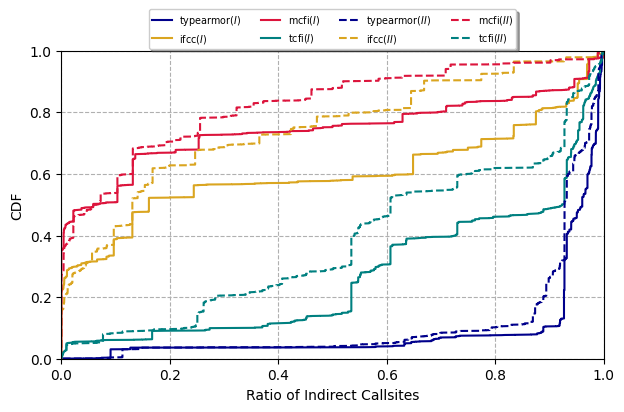

In [9]:
def plotMetrics(bench, obj):
    def exactMatchTable(match_type, nu):
        model_stat = obj.model_stat

        match_count = {}
        
        # specInt.
        match_count["SPECint"] = {"tp":[], "fp":[]}
        tp_ = []
        fp_ = []
        for benchmark in specint:
            tp, fp = model_stat[benchmark][match_type]["tp"], model_stat[benchmark][match_type]["fp"]
            tp_.extend(tp)
            fp_.extend(fp)
        match_count["SPECint"]["tp"] = tp_
        match_count["SPECint"]["fp"] = fp_
        
        # specInt.
        match_count["SPECfp"] = {"tp":[], "fp":[]}
        tp_ = []
        fp_ = []
        for benchmark in specfp:
            tp, fp = model_stat[benchmark][match_type]["tp"], model_stat[benchmark][match_type]["fp"]
            tp_.extend(tp)
            fp_.extend(fp)
        match_count["SPECfp"]["tp"] = tp_
        match_count["SPECfp"]["fp"] = fp_
        
        #realWorld.
        for benchmark in realworld:
            match_count[benchmark] = {"tp":[], "fp":[]}
            match_count[benchmark]["tp"] = model_stat[benchmark][match_type]["tp"]
            match_count[benchmark]["fp"] = model_stat[benchmark][match_type]["fp"]
        
        #for bench in realworld:
        #    pd.Series(match_count["tor"]["tp"]).hist(cumulative=True, histtype='step')
        #    break
        
        #fig, ax = plt.subplots()
        sorted_data = np.sort([item for k,v in model_stat.items() for item in v[match_type]["tp"]])
        cdf = np.linspace(0, 1, len(sorted_data))
        
        # Set Marker.
        linestyle = "dashed" if "opt" in bench else "solid"
        
        # Label Name.
        label = match_type+"($II$)" if "opt" in bench else match_type+"($I$)"
        
        # Plot the CDF
        plt.plot(sorted_data, cdf, label=label, color=colors[nu-1], linestyle=linestyle)
    
    colors=["darkblue", "goldenrod", "crimson", "teal"]
    exactMatchTable("typearmor", 1)
    exactMatchTable("ifcc", 2)
    exactMatchTable("mcfi", 3)
    exactMatchTable("tcfi", 4)

fig, ax = plt.subplots()
fig.set_dpi(100)
fig.set_size_inches(7, 4)

plotMetrics("spec", spec)

# print("-------")
plotMetrics("spec-opt-stripped", spec_opt_str)

plt.grid(True, linestyle='--')
plt.legend(loc='upper center', fancybox=True, shadow=True, ncol=4, bbox_to_anchor=(0.5, 1.15),\
          fontsize="x-small")
plt.xlabel('Ratio of Indirect Callsites')
ax.set_ylim(0,1)
ax.set_xlim(0,1)
plt.ylabel('CDF')
plt.savefig(f"/nfs/volatile/zephyr/Ruturaj/cfi_project/figures/cdf_t.png")
# plt.title('Cumulative Distribution Function')
plt.show()

In [10]:
def displayMetrics(bench, obj):
    print("\\begin{table*}[h!]")
    print("\\centering")
    def exactMatchTable(match_type, label):
        model_stat = obj.model_stat

        match_count = {}
        
        # specInt.
        tp_ = []
        fp_ = []
        for benchmark in specint:
            tp, fp = model_stat[benchmark][match_type]["tp"], model_stat[benchmark][match_type]["fp"]
            tp_.extend(tp)
            fp_.extend(fp)
        match_count["SPECint"] = pd.Series(tp_).describe(percentiles=[.9]).to_list()
        match_count["SPECint"].extend(pd.Series(fp_).describe(percentiles=[.9])[1:])
        
        # specFp.
        tp_ = []
        fp_ = []
        for benchmark in specfp:
            tp, fp = model_stat[benchmark][match_type]["tp"], model_stat[benchmark][match_type]["fp"]
            tp_.extend(tp)
            fp_.extend(fp)
        match_count["SPECfp"] = pd.Series(tp_).describe(percentiles=[.9]).to_list()
        match_count["SPECfp"].extend(pd.Series(fp_).describe(percentiles=[.9])[1:])
        
        #realWorld.
        for benchmark in realworld:
            match_count[benchmark] = \
            pd.Series(model_stat[benchmark][match_type]["tp"]).describe(percentiles=[.9]).to_list()
            match_count[benchmark].\
            extend(pd.Series(model_stat[benchmark][match_type]["fp"]).describe(percentiles=[.9])[1:])
        
        headers = ["Benchmark", "Count", "Mean", "Std", "Min", "Med", "90thp", "Max", \
            "Mean", "Std", "Min", "Med", "90thp", "Max"]
        table = tabulate([[k]+[f"{x:.2f}" if not np.isnan(x) else x for x in v]\
                            for k,v in match_count.items()], \
                            headers=headers, tablefmt="latex")
        print("\\resizebox{12cm}{!}{")
        print("\\begin{subtable}[]{1.1\\textwidth}")
        print("\\centering")
        table = table.split("\n")
        # replace first row with custom latex statement.
        table[0] = "\\begin{tabular}[]{|l|||r||r|r|r|r|r|r||r|r|r|r|r|r|r|}"
        # First print only two rows.
        [print(line) for line in table[:2]]
        print("\\multicolumn{2}{|c||}{} & \\multicolumn{6}{|c||}{$RelativeCTR_T$} "
            "& \\multicolumn{6}{|c|}{$RelativeCTR_F$}\\\\")
        print("\\hline")
        [print(line) for line in table[2:]]
        print(f"\\caption{{{match_type}}}\\label{{table:{bench}:rtcr:{label}}}")
        print("\\end{subtable}")
        print("}")
    
    
    exactMatchTable("typearmor", 1)
    exactMatchTable("ifcc", 2)
    exactMatchTable("mcfi", 3)
    exactMatchTable("tcfi", 4)

    debug = "out" if "stripped" in bench else ""
    print("\caption{Comparison of 4 different policies ({\it TypeArmor}, {\it IFCC}, {\it MCFI}) "
      f"applied for binaries compiled with{debug} debug symbols using {{\\tt RelativeCTR}} metrics."
       "The `count` depicts number of callsites, and subsequent columns display Mean, Standard "
       "Deviation, Minimum, Median, 90\\textsuperscript{th} percentile and Maximum aggregate "
       f"results for each {bench} benchmark.}}")
    print(f"\\label{{table:{bench}:rctr}}")
    print("\\end{table*}")

displayMetrics("spec", spec)

# print("-------")
displayMetrics("spec-opt-stripped", spec_opt_str)

\begin{table*}[h!]
\centering
\resizebox{12cm}{!}{
\begin{subtable}[]{1.1\textwidth}
\centering
\begin{tabular}[]{|l|||r||r|r|r|r|r|r||r|r|r|r|r|r|r|}
\hline
\multicolumn{2}{|c||}{} & \multicolumn{6}{|c||}{$RelativeCTR_T$} & \multicolumn{6}{|c|}{$RelativeCTR_F$}\\
\hline
 Benchmark           &   Count &   Mean &   Std &   Min &   Med &   90thp &   Max &   Mean &   Std &   Min &   Med &   90thp &   Max \\
\hline
 SPECint             &   20304 &   0.93 &  0.08 &  0    &  0.93 &    0.99 &     1 &   0.24 &  0.17 &     0 &  0.33 &    0.41 &  0.95 \\
 SPECfp              &    1179 &   0.91 &  0.1  &  0.06 &  0.94 &    0.97 &     1 &   0.13 &  0.15 &     0 &  0.07 &    0.22 &  0.77 \\
 nginx-1.22.1        &     448 &   0.92 &  0.2  &  0.04 &  0.97 &    0.98 &     1 &   0.03 &  0.1  &     0 &  0.01 &    0.01 &  0.77 \\
 postgresql-12.0     &    9367 &   0.8  &  0.33 &  0.04 &  0.96 &    0.98 &     1 &   0.02 &  0.08 &     0 &  0    &    0    &  0.96 \\
 trafficserver-6.2.3 &    8311 &   0.93 &

\resizebox{12cm}{!}{
\begin{subtable}[]{1.1\textwidth}
\centering
\begin{tabular}[]{|l|||r||r|r|r|r|r|r||r|r|r|r|r|r|r|}
\hline
\multicolumn{2}{|c||}{} & \multicolumn{6}{|c||}{$RelativeCTR_T$} & \multicolumn{6}{|c|}{$RelativeCTR_F$}\\
\hline
 Benchmark           &   Count &   Mean &   Std &   Min &   Med &   90thp &   Max &   Mean &   Std &   Min &   Med &   90thp &   Max \\
\hline
 SPECint             &   20304 &   0.13 &  0.21 &     0 &  0.06 &    0.52 &  1    &   0.66 &  0.39 &  0    &  0.99 &       1 &     1 \\
 SPECfp              &    1179 &   0.19 &  0.33 &     0 &  0    &    0.92 &  1    &   0.67 &  0.43 &  0    &  1    &       1 &     1 \\
 nginx-1.22.1        &     448 &   0.24 &  0.19 &     0 &  0.26 &    0.61 &  0.61 &   0.72 &  0.34 &  0.15 &  0.96 &       1 &     1 \\
 postgresql-12.0     &    9367 &   0.23 &  0.28 &     0 &  0.07 &    0.71 &  1    &   0.76 &  0.35 &  0    &  0.97 &       1 &     1 \\
 trafficserver-6.2.3 &    8311 &   0.11 &  0.16 &     0 &  0    &    0.

In [11]:
def typearmorplot(bench, obj):
    correct_void = 0
    incorrect_void = 0
    correct_nonvoid = 0
    incorrect_nonvoid = 0
    for benchmark, df in obj.callsite_dict.items():
        for i, row in df.iterrows():
            call = row.iloc[1:8].to_numpy()
            ret = row.iloc[8]
            call_ida = row.iloc[10:17].to_numpy()
            ret_ida = row.iloc[17]
            
            # Collect void or non-void callsites.
            key = decode(ret, arm=True)
            key_ida = decode(ret_ida, arm=True)
            
            # For void.
            if key == "0":
                if key == key_ida:
                    correct_void += 1
                else:
                    incorrect_void += 1
            # For non-void.
            else:
                if key == key_ida:
                    correct_nonvoid += 1
                else:
                    incorrect_nonvoid += 1
    
    y1 = [correct_void, incorrect_void, correct_nonvoid, incorrect_nonvoid]
    print(y1)
    
    correct_void = 0
    incorrect_void = 0
    correct_nonvoid = 0
    incorrect_nonvoid = 0
    # Todo: repeat this for function dictionary as well.
    for benchmark, df in obj.fun_dict.items():
        for i, row in df.iterrows():
            fun = row.iloc[1:8].to_numpy()
            fun_ret = row.iloc[8]
            fun_ida = row.iloc[9:16].to_numpy()
            fun_ret_ida = row.iloc[16]
            
            # Collect void or non-void callsites.
            key = decode(fun_ret, arm=True)
            key_ida = decode(fun_ret_ida, arm=True)
            
            # For void.
            if key == "0":
                if key == key_ida:
                    correct_void += 1
                else:
                    incorrect_void += 1
            # For non-void.
            else:
                if key == key_ida:
                    correct_nonvoid += 1
                else:
                    incorrect_nonvoid += 1
    
    y2 = [correct_void, incorrect_void, correct_nonvoid, incorrect_nonvoid]
    print(y2)
    
    labels = ["Void T", "Void F", "Non-Void T", "Non-Void F"]

typearmorplot("spec", spec)
typearmorplot("spec-opt-stripped", spec_opt_str)

[22733, 1014, 21955, 2419]
[71243, 7624, 96844, 693]
[21537, 2210, 21979, 2395]
[21003, 57864, 96777, 760]


0.885933376280626
0.9491054624611687
0.8825253008042226
0.8509047413890841


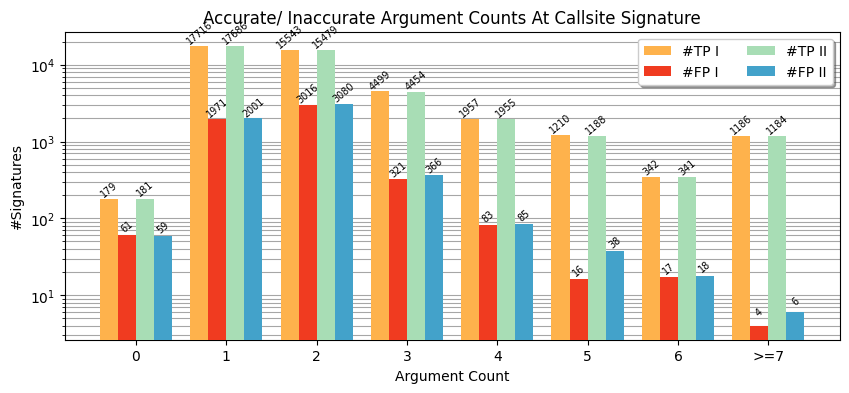

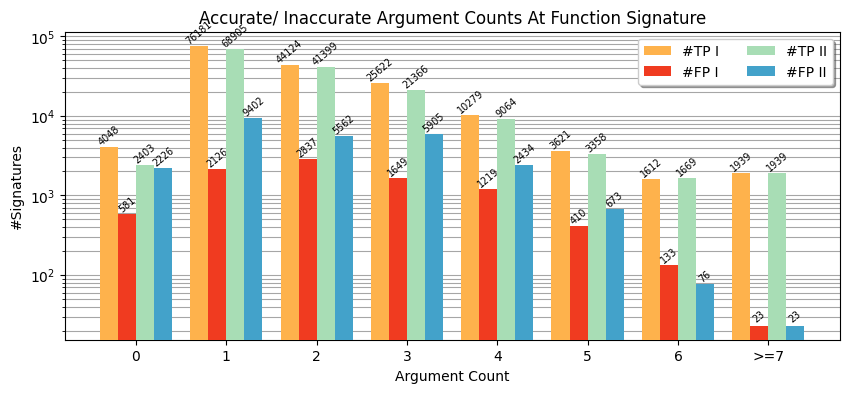

In [12]:
def set_fig_param(fig):
    fig.set_dpi(100)
    fig.set_size_inches(10, 4)

    
def set_ax_param(ax, labels, graph_type):
    ax.set_xticks([i-(w/2) for i in np.arange(len(labels))], labels)
    ax.set_title(f"Accurate/ Inaccurate Argument Counts At {graph_type} Signature")

    ax.set_ylabel(f"#Signatures")
    ax.set_xlabel("Argument Count")

    ax.legend(fancybox=True, shadow=True, ncol=2)
    ax.set_yscale('log')


def plotCounts(types, bench, ax, color):
    
    dic = {key:types[key] for key in sorted(types.keys())}
    
    y1 = [v[0] for k,v in types.items()]
    y2 = [v[1] for k,v in types.items()]
    labels = [k for k in types.keys()]
    labels[-1] = ">=7"
    
    acc = 0 if "opt" in bench else -2
    
    bar1 = [i+w*acc for i in np.arange(len(labels))]
    bar2 = [i+w for i in bar1]
    
    colors = ['#feb24c', '#f03b20', '#a8ddb5', '#43a2ca']
    
    label = "II" if "opt" in bench else "I"
    ax_bar1 = ax.bar(bar1, y1, w, color=colors[color], label="#TP "+label, zorder=3)
    ax_bar2 = ax.bar(bar2, y2, w, color=colors[color+1], label="#FP "+label, zorder=3)
        
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height+1, \
                    '%d' % int(height), \
                    ha='center', va='bottom', fontsize="x-small", rotation=40)
    autolabel(ax_bar1)
    autolabel(ax_bar2)
    
    return labels

def typearmorCount(bench, obj, ax1, ax2, color):
    counts = {i:[0,0] for i in range(0,8)}
    for benchmark, df in obj.callsite_dict.items():
        for i, row in df.iterrows():
            call = row.iloc[1:8].to_numpy()
            ret = row.iloc[8]
            call_ida = row.iloc[10:17].to_numpy()
            ret_ida = row.iloc[17]
            
            # Collect void or non-void callsites.
            args = [x for x in call if x>0]
            ida_args = [x for x in call_ida if x>0]
            
            # Keep callsites and function with more than or equal to 7 args.
            # with same encoding 32.
            if len(args) >= 7:
                args = [32 for _ in range(6)]
            if len(ida_args) >= 7:
                ida_args = [32 for _ in range(6)]
            
            key = len(args)
            key_ida = len(ida_args)

            if args and args[0] == 32:
                if key == key_ida:
                    counts[7][0] += 1
                else:
                    counts[7][1] += 1
            else:
                if key == key_ida:
                    counts[key][0] += 1
                else:
                    counts[key][1] += 1
    
    counts_fun = {i:[0,0] for i in range(0,8)}
    # Todo: repeat this for function dictionary as well.
    for benchmark, df in obj.fun_dict.items():
        for i, row in df.iterrows():
            fun = row.iloc[1:8].to_numpy()
            fun_ret = row.iloc[8]
            fun_ida = row.iloc[9:16].to_numpy()
            fun_ret_ida = row.iloc[16]
            
            # Collect void or non-void callsites.
            args = [x for x in fun if x>0]
            ida_args = [x for x in fun_ida if x>0]
            
            # Keep callsites and function with more than or equal to 7 args.
            # with same encoding 32.
            if len(args) >= 7:
                args = [32 for _ in range(6)]
            if len(ida_args) >= 7:
                ida_args = [32 for _ in range(6)]
            
            key = len(args)
            key_ida = len(ida_args)
            
            if args and args[0] == 32:
                if key == key_ida:
                    counts_fun[7][0] += 1
                else:
                    counts_fun[7][1] += 1
            else:
                if key == key_ida:
                    counts_fun[key][0] += 1
                else:
                    counts_fun[key][1] += 1
    
    print(sum([v[0] for v in counts.values()])/sum([v[0]+v[1] for v in counts.values()]))
    print(sum([v[0] for v in counts_fun.values()])/sum([v[0]+v[1] for v in counts_fun.values()]))
    
    labels = plotCounts(counts, bench, ax1, color)
    fun_labels = plotCounts(counts_fun, bench, ax2, color)
    
    return labels, fun_labels


fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

set_fig_param(fig1)
set_fig_param(fig2)

# Set the bar width.
w = 0.2

plt.set_cmap('Pastel1')

labels, fun_labels = typearmorCount("spec", spec, ax1, ax2, 0)
labels, fun_labels = typearmorCount("spec-opt-stripped", spec_opt_str, ax1, ax2, 2)

set_ax_param(ax1, labels, "Callsite")
set_ax_param(ax2, fun_labels, "Function")


ax1.grid(axis='y', which="both", zorder=0, ls="-", color='0.65')
ax2.grid(axis='y', which="both", zorder=0, ls="-", color='0.65')
plt.show()

fig1.savefig(f"/nfs/volatile/zephyr/Ruturaj/cfi_project/figures/callsites_counts.png")
fig2.savefig(f"/nfs/volatile/zephyr/Ruturaj/cfi_project/figures/functions_counts.png")
plt.close(fig1)
plt.close(fig2)

0.6231759142874245
0.8883011603197106
0.4438144329896907
0.4511828639428798


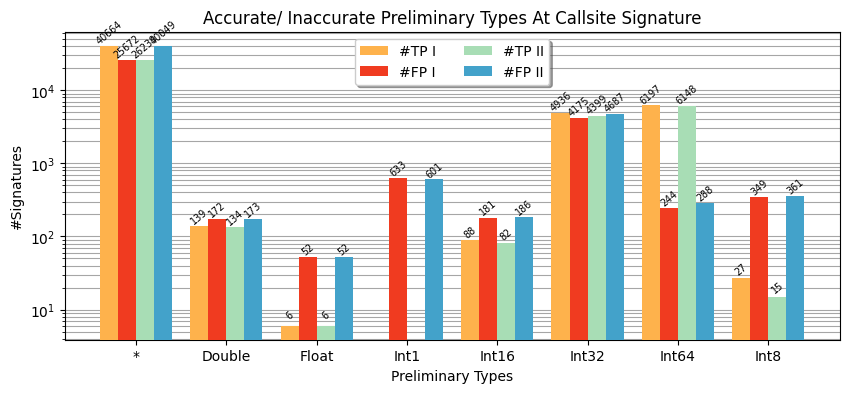

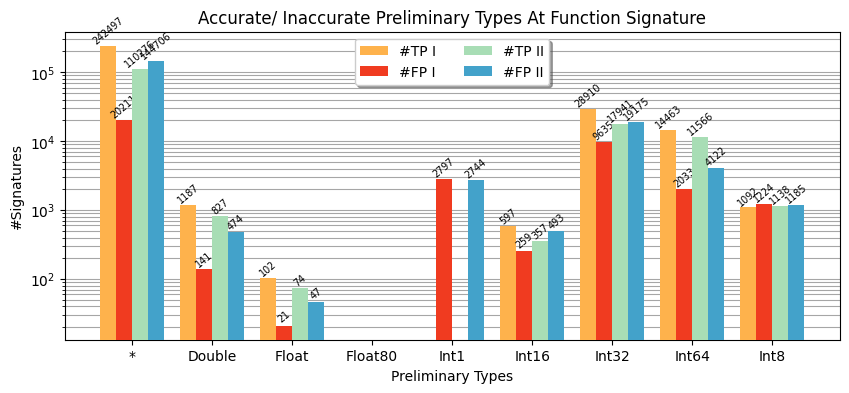

In [13]:
def set_fig_param(fig):
    fig.set_dpi(100)
    fig.set_size_inches(10, 4)

    
def set_ax_param(ax, labels, graph_type):
    ax.set_xticks([i-(w/2) for i in np.arange(len(labels))], labels)
    ax.set_title(f"Accurate/ Inaccurate Preliminary Types At {graph_type} Signature")

    ax.set_ylabel(f"#Signatures")
    ax.set_xlabel("Preliminary Types")

    ax.legend(fancybox=True, shadow=True, ncol=2, loc="upper center")
    ax.set_yscale('log')

def plottypes(types, bench, ax, color):
    types = {key:types[key] for key in sorted(types.keys())}
    
    y1 = [v[0] for k,v in types.items()]
    y2 = [v[1] for k,v in types.items()]

    labels = [k for k in types.keys()]
    
    acc = 0 if "opt" in bench else -2
    
    bar1 = [i+w*acc for i in np.arange(len(labels))]
    bar2 = [i+w for i in bar1]
    
    colors = ['#feb24c', '#f03b20', '#a8ddb5', '#43a2ca']
    
    label = "II" if "opt" in bench else "I"
    ax_bar1 = ax.bar(bar1, y1, w, color=colors[color], label="#TP "+label, zorder=3)
    ax_bar2 = ax.bar(bar2, y2, w, color=colors[color+1], label="#FP "+label, zorder=3)
        
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            if height == 0: continue
            ax.text(rect.get_x() + rect.get_width()/2., height+1, \
                    '%d' % int(height), \
                    ha='center', va='bottom', fontsize="x-small", rotation=40)
    autolabel(ax_bar1)
    autolabel(ax_bar2)
    
    return labels


def ifccTypes(bench, obj, ax1, ax2, color):
    types = defaultdict(lambda: [0,0])
    for benchmark, df in obj.callsite_dict.items():
        for i, row in df.iterrows():
            call = row.iloc[1:8].to_numpy()
            ret = row.iloc[8]
            call_ida = row.iloc[10:17].to_numpy()
            ret_ida = row.iloc[17]
            
            # Collect void or non-void callsites.
            args = [x for x in call if x>0]
            ida_args = [x for x in call_ida if x>0]
            
            # Keep callsites and function with more than or equal to 7 args.
            # with same encoding 32.
            if len(args) >= 7:
                args = [32 for _ in range(6)]
            if len(ida_args) >= 7:
                ida_args = [32 for _ in range(6)]
            
            for x,y in zip(args, ida_args):
                key = decode(x, False)
                key_ida = decode(y, False)
                # Ignore additional arugments detected by ida.
                if x == 0:
                    continue
                if key == key_ida:
                    types[key][0] += 1
                else:
                    types[key][1] += 1
    
    types_fun = defaultdict(lambda: [0,0])
    # Todo: repeat this for function dictionary as well.
    for benchmark, df in obj.fun_dict.items():
        for i, row in df.iterrows():
            fun = row.iloc[1:8].to_numpy()
            fun_ret = row.iloc[8]
            fun_ida = row.iloc[9:16].to_numpy()
            fun_ret_ida = row.iloc[16]
            
            # Collect void or non-void callsites.
            args = [x for x in fun if x>0]
            ida_args = [x for x in fun_ida if x>0]
            
            # Keep callsites and function with more than or equal to 7 args.
            # with same encoding 32.
            if len(args) >= 7:
                args = [32 for _ in range(6)]
            if len(ida_args) >= 7:
                ida_args = [32 for _ in range(6)]
            
            for x,y in zip(args, ida_args):
                key = decode(x, False)
                key_ida = decode(y, False)
                if x == 0:
                    continue
                #    types_fun[key_ida][1] += 1
                if key == key_ida:
                    types_fun[key][0] += 1
                else:
                    types_fun[key][1] += 1
    
    types.pop("unc.", None)
    #print(types)
    types_fun.pop("unc.", None)
    #print(types_fun)
    
    if "Float80128" not in types_fun:
        types_fun["Float80"] = [0,0]
    else:
        types_fun["Float80"] = types_fun.pop("Float80128", [0,0])
        
    types_fun.pop("Undef.", None)
    
    print(sum([v[0] for v in types.values()])/sum([v[0]+v[1] for v in types.values()]))
    print(sum([v[0] for v in types_fun.values()])/sum([v[0]+v[1] for v in types_fun.values()]))
    
    labels = plottypes(types, bench, ax1, color)
    fun_labels = plottypes(types_fun, bench, ax2, color)
    
    return labels, fun_labels

    
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

set_fig_param(fig1)
set_fig_param(fig2)

# Set the bar width.
w = 0.2

plt.set_cmap('Pastel1')

labels, fun_labels = ifccTypes("spec", spec, ax1, ax2, 0)
labels, fun_labels = ifccTypes("spec-opt-stripped", spec_opt_str, ax1, ax2, 2)


set_ax_param(ax1, labels, "Callsite")
set_ax_param(ax2, fun_labels, "Function")


ax1.grid(axis='y', which="both", zorder=0, ls="-", color='0.65')
ax2.grid(axis='y', which="both", zorder=0, ls="-", color='0.65')
plt.show()

fig1.savefig(f"/nfs/volatile/zephyr/Ruturaj/cfi_project/figures/callsites_types.png")
fig2.savefig(f"/nfs/volatile/zephyr/Ruturaj/cfi_project/figures/functions_types.png")
plt.close(fig1)
plt.close(fig2)

0.3536089001447178
0.8383794935822282
0.08997103548153512
0.04801123216540775


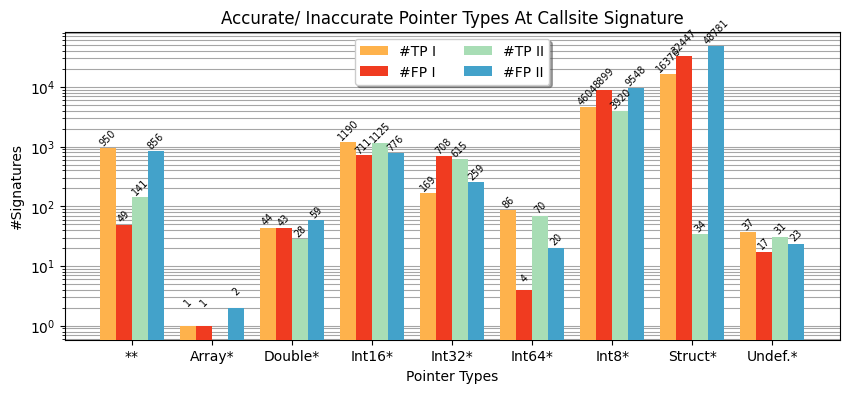

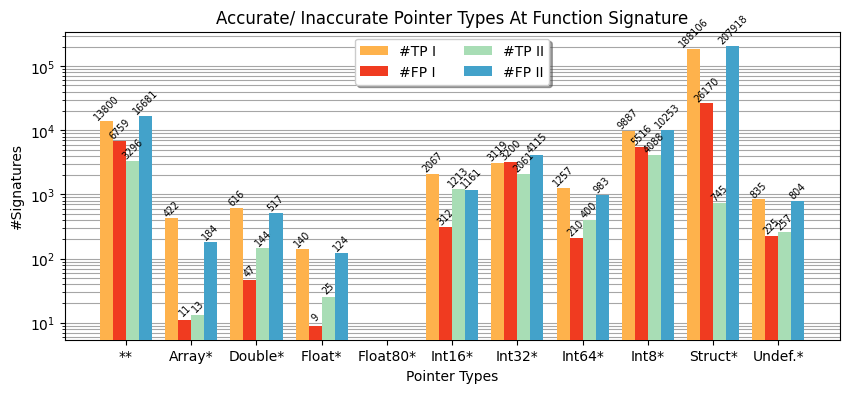

In [14]:
def set_fig_param(fig):
    fig.set_dpi(100)
    fig.set_size_inches(10, 4)

    
def set_ax_param(ax, labels, graph_type):
    ax.set_xticks([i-(w/2) for i in np.arange(len(labels))], labels)
    ax.set_title(f"Accurate/ Inaccurate Pointer Types At {graph_type} Signature")

    ax.set_ylabel(f"#Signatures")
    ax.set_xlabel("Pointer Types")

    ax.legend(fancybox=True, shadow=True, ncol=2, loc="upper center")
    ax.set_yscale('log')


def plotpointers(types, bench, ax, color):
    types = {key:types[key] for key in sorted(types.keys())}
    y1 = [v[0] for k,v in types.items()]
    y2 = [v[1] for k,v in types.items()]
    labels = [k for k in types.keys()]
    
    acc = 0 if "opt" in bench else -2
    
    bar1 = [i+w*acc for i in np.arange(len(labels))]
    bar2 = [i+w for i in bar1]
    
    colors = ['#feb24c', '#f03b20', '#a8ddb5', '#43a2ca']
    
    label = "II" if "opt" in bench else "I"
    ax_bar1 = ax.bar(bar1, y1, w, color=colors[color], label="#TP "+label, zorder=3)
    ax_bar2 = ax.bar(bar2, y2, w, color=colors[color+1], label="#FP "+label, zorder=3)
    
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            if height == 0: continue
            ax.text(rect.get_x() + rect.get_width()/2., height+1, \
                    '%d' % int(height), \
                    ha='center', va='bottom', fontsize="x-small", rotation=45)
    autolabel(ax_bar1)
    autolabel(ax_bar2)
    return labels


def mcfiTypes(bench, obj, ax1, ax2, color):
    types = defaultdict(lambda: [0,0])
    for benchmark, df in obj.callsite_dict.items():
        for i, row in df.iterrows():
            call = row.iloc[1:8].to_numpy()
            ret = row.iloc[8]
            call_ida = row.iloc[10:17].to_numpy()
            ret_ida = row.iloc[17]
            
            # Collect void or non-void callsites.
            args = [x for x in call if x>0]
            ida_args = [x for x in call_ida if x>0]
            
            # Keep callsites and function with more than or equal to 7 args.
            # with same encoding 32.
            if len(args) >= 7:
                args = [32 for _ in range(6)]
            if len(ida_args) >= 7:
                ida_args = [32 for _ in range(6)]
            
            for x,y in zip(args, ida_args):
                key = decode(x, True)
                key_ida = decode(y, True)
                # Ignore additional arugments detected by ida.
                if x == 0:
                    continue
                if key == key_ida:
                    types[key][0] += 1
                else:
                    types[key][1] += 1
    
    types_fun = defaultdict(lambda: [0,0])
    # Todo: repeat this for function dictionary as well.
    for benchmark, df in obj.fun_dict.items():
        for i, row in df.iterrows():
            fun = row.iloc[1:8].to_numpy()
            fun_ret = row.iloc[8]
            fun_ida = row.iloc[9:16].to_numpy()
            fun_ret_ida = row.iloc[16]
            
            # Collect void or non-void callsites.
            args = [x for x in fun if x>0]
            ida_args = [x for x in fun_ida if x>0]
            
            # Keep callsites and function with more than or equal to 7 args.
            # with same encoding 32.
            if len(args) >= 7:
                args = [32 for _ in range(6)]
            if len(ida_args) >= 7:
                ida_args = [32 for _ in range(6)]
            
            for x,y in zip(args, ida_args):
                key = decode(x, True)
                key_ida = decode(y, True)
                if x == 0:
                    continue
                #    types_fun[key_ida][1] += 1
                if key == key_ida:
                    types_fun[key][0] += 1
                else:
                    types_fun[key][1] += 1
    
    types.pop("unc.", None)
    for k in list(types.keys()):
        if "*" not in k:
            types.pop(k, None)
    #print(types)
    types_fun.pop("unc.", None)
    for k in list(types_fun.keys()):
        if "*" not in k:
            types_fun.pop(k, None)
    #print(types_fun)
    if "Float80128*" not in types_fun:
        types_fun["Float80*"] = [0,0]
    else:
        types_fun["Float80*"] = types_fun.pop("Float80128*", [0,0])
        
    print(sum([v[0] for v in types.values()])/sum([v[0]+v[1] for v in types.values()]))
    print(sum([v[0] for v in types_fun.values()])/sum([v[0]+v[1] for v in types_fun.values()]))
    
    labels = plotpointers(types, bench, ax1, color)
    fun_labels = plotpointers(types_fun, bench, ax2, color)
    
    return labels, fun_labels


fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

set_fig_param(fig1)
set_fig_param(fig2)

# Set the bar width.
w = 0.2

plt.set_cmap('Pastel1')

labels, fun_labels = mcfiTypes("spec", spec, ax1, ax2, 0)
labels, fun_labels = mcfiTypes("spec-opt-stripped", spec_opt_str, ax1, ax2, 2)


set_ax_param(ax1, labels, "Callsite")
set_ax_param(ax2, fun_labels, "Function")


ax1.grid(axis='y', which="both", zorder=0, ls="-", color='0.65')
ax2.grid(axis='y', which="both", zorder=0, ls="-", color='0.65')
plt.show()

fig1.savefig(f"/nfs/volatile/zephyr/Ruturaj/cfi_project/figures/callsites_pointers.png")
fig2.savefig(f"/nfs/volatile/zephyr/Ruturaj/cfi_project/figures/functions_pointers.png")
plt.close(fig1)
plt.close(fig2)

0.9366376600602191
0.9558355449901744
0.9302153506350083
0.8730773746624398


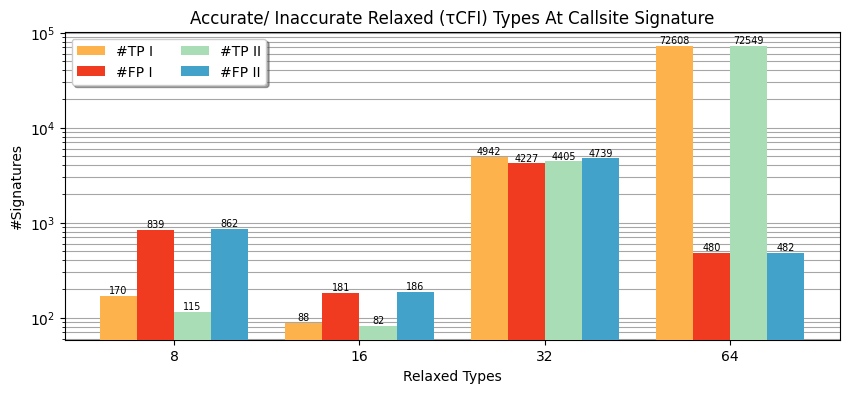

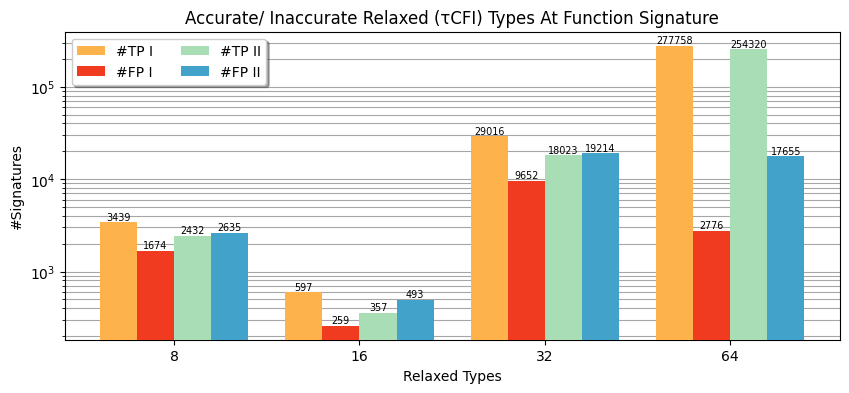

In [15]:
def set_fig_param(fig):
    fig.set_dpi(100)
    fig.set_size_inches(10, 4)
    
def set_ax_param(ax, labels, graph_type):
    ax.set_xticks([i-(w/2) for i in np.arange(len(labels))], list(map(lambda x: int(x)*8, labels)))
    ax.set_title(f"Accurate/ Inaccurate Relaxed (\u03C4CFI) Types At {graph_type} Signature")

    ax.set_ylabel(f"#Signatures")
    ax.set_xlabel("Relaxed Types")

    ax.legend(fancybox=True, shadow=True, ncol=2,)
    ax.set_yscale('log')

def plottcfi(types, bench, ax, color):
    types = {key:types[key] for key in sorted(types.keys())}
    
    types.pop("9", None)
    y1 = [v[0] for k,v in types.items()]
    y2 = [v[1] for k,v in types.items()]
    labels = [k for k in types.keys()]
    
    acc = 0 if "opt" in bench else -2
    
    bar1 = [i+w*acc for i in np.arange(len(labels))]
    bar2 = [i+w for i in bar1]
    
    colors = ['#feb24c', '#f03b20', '#a8ddb5', '#43a2ca']
    
    label = "II" if "opt" in bench else "I"
    ax_bar1 = ax.bar(bar1, y1, w, color=colors[color], label="#TP "+label, zorder=3)
    ax_bar2 = ax.bar(bar2, y2, w, color=colors[color+1], label="#FP "+label, zorder=3)
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            if height == 0: continue
            ax.text(rect.get_x() + rect.get_width()/2., height+1, \
                    '%d' % int(height), \
                    ha='center', va='bottom', fontsize="x-small")
    autolabel(ax_bar1)
    autolabel(ax_bar2)
    
    return labels

def tcfiTypes(bench, obj, ax1, ax2, color):
    types = defaultdict(lambda: [0,0])
    for benchmark, df in obj.callsite_dict.items():
        for i, row in df.iterrows():
            call = row.iloc[1:8].to_numpy()
            ret = row.iloc[8]
            call_ida = row.iloc[10:17].to_numpy()
            ret_ida = row.iloc[17]
            
            args = [convert_type(x) for x in call if x>0]
            ida_args = [convert_type(x) for x in call_ida if x>0]
            
            # Keep callsites and function with more than or equal to 7 args.
            # with same encoding 32.
            if len(args) >= 7:
                args = ["9" for _ in range(6)]
            if len(ida_args) >= 7:
                ida_args = ["9" for _ in range(6)]
            
            for x,y in zip(args, ida_args):
                key = x
                key_ida = y
                # Ignore additional arugments detected by ida.
                if key == key_ida:
                    types[key][0] += 1
                else:
                    types[key][1] += 1
    
    types_fun = defaultdict(lambda: [0,0])
    # Todo: repeat this for function dictionary as well.
    for benchmark, df in obj.fun_dict.items():
        for i, row in df.iterrows():
            fun = row.iloc[1:8].to_numpy()
            fun_ret = row.iloc[8]
            fun_ida = row.iloc[9:16].to_numpy()
            fun_ret_ida = row.iloc[16]
            
            # Collect void or non-void callsites.
            args = [convert_type(x) for x in fun if x>0]
            ida_args = [convert_type(x) for x in fun_ida if x>0]
            
            # Keep callsites and function with more than or equal to 7 args.
            # with same encoding 32.
            if len(args) >= 7:
                args = ["9" for _ in range(6)]
            if len(ida_args) >= 7:
                ida_args = ["9" for _ in range(6)]
            
            for x,y in zip(args, ida_args):
                key = x
                key_ida = y
                if key == key_ida:
                    types_fun[key][0] += 1
                else:
                    types_fun[key][1] += 1
    
    #print(types_fun)
    types_fun.pop("9", None)
    
    print(sum([v[0] for v in types.values()])/sum([v[0]+v[1] for v in types.values()]))
    print(sum([v[0] for v in types_fun.values()])/sum([v[0]+v[1] for v in types_fun.values()]))
    
    labels = plottcfi(types, bench, ax1, color)
    fun_labels = plottcfi(types_fun, bench, ax2, color)
    #plottcfi(types_fun)
    return labels, fun_labels

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

set_fig_param(fig1)
set_fig_param(fig2)

# Set the bar width.
w = 0.2

plt.set_cmap('Pastel1')

labels, fun_labels = tcfiTypes("spec", spec, ax1, ax2, 0)
labels, fun_labels = tcfiTypes("spec-opt-stripped", spec_opt_str, ax1, ax2, 2)

set_ax_param(ax1, labels, "Callsite")
set_ax_param(ax2, fun_labels, "Function")

ax1.grid(axis='y', which="both", zorder=0, ls="-", color='0.65')
ax2.grid(axis='y', which="both", zorder=0, ls="-", color='0.65')
plt.show()

fig1.savefig(f"/nfs/volatile/zephyr/Ruturaj/cfi_project/figures/callsites_tcfi.png")
fig2.savefig(f"/nfs/volatile/zephyr/Ruturaj/cfi_project/figures/functions_tcfi.png")
plt.close(fig1)
plt.close(fig2)

In [16]:
def tcfiTypes(bench, obj, ax1, ax2, color):
    types = defaultdict(lambda: [0,0])
    for benchmark, df in obj.callsite_dict.items():
        for i, row in df.iterrows():
            call = row.iloc[1:8].to_numpy()
            ret = row.iloc[8]
            call_ida = row.iloc[10:17].to_numpy()
            ret_ida = row.iloc[17]
            
            key = convert_type(ret)
            key_ida = convert_type(ret_ida)
            
            if key == key_ida:
                types[key][0] += 1
            else:
                types[key][1] += 1
    
    types_fun = defaultdict(lambda: [0,0])
    # Todo: repeat this for function dictionary as well.
    for benchmark, df in obj.fun_dict.items():
        for i, row in df.iterrows():
            fun = row.iloc[1:8].to_numpy()
            fun_ret = row.iloc[8]
            fun_ida = row.iloc[9:16].to_numpy()
            fun_ret_ida = row.iloc[16]
            
            key = convert_type(fun_ret)
            key_ida = convert_type(fun_ret_ida)
            
            if key == key_ida:
                types_fun[key][0] += 1
            else:
                types_fun[key][1] += 1
    
    #print(types_fun)
    types_fun.pop("9", None)
    
    types = {key:types[key] for key in sorted(types.keys())}
    types_fun = {key:types_fun[key] for key in sorted(types_fun.keys())}
    
    print(sum([v[0] for v in types.values()])/sum([v[0]+v[1] for v in types.values()]))
    print(sum([v[0] for v in types_fun.values()])/sum([v[0]+v[1] for v in types_fun.values()]))
    
    print(types)
    print(types_fun)

tcfiTypes("spec", spec, ax1, ax2, 0)
tcfiTypes("spec-opt-stripped", spec_opt_str, ax1, ax2, 2)

0.874503854865859
0.8908074646833405
{'0': [22733, 1014], '1': [1557, 1357], '2': [538, 155], '4': [2579, 2910], '8': [14675, 603]}
{'0': [71243, 7624], '1': [9617, 1148], '2': [227, 376], '4': [7480, 9249], '8': [68575, 865]}
0.8131792772386276
0.5477766944060225
{'0': [21537, 2210], '1': [1454, 1460], '2': [214, 479], '4': [1295, 4194], '8': [14631, 647]}
{'0': [21003, 57864], '1': [6082, 4683], '2': [272, 331], '4': [1087, 15642], '8': [68186, 1254]}
